<a href="https://colab.research.google.com/github/xiaoyo8520/xiaoyo8520.github.io/blob/main/Diffusion_Model_and_Its_Customization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GenAI ML HW9 Diffusion Model and Its Customization



In this homework, you will observe the generation process of the diffusion models, and use Custom Diffusion and BLIP-Diffusion to customize the generated images.

**TODOs**:
- Task 1: Run the demo to observe diffusion model, and answer the questions on NTUCOOL
- Task 2-1: Tune the hyperparameters and run Custom Diffusion
- Task 2-2: Tune the hyperparameters and run BLIP-Diffusion
- Download the results of Task 2-1 & 2-2, and upload to JudgeBoi

**Tips**: At the top of each cell, it shows whether you need to change parameters in that cell.

**Homework slides**: [link](https://docs.google.com/presentation/d/1aHR1-1GYp6wy2m4LcgZk9tdqNFITF73IVceMv_RKXbw/edit?usp=sharing)

*Some of the codes in this notebook are modified from [ref1](https://huggingface.co/docs/diffusers/en/api/pipelines/blip_diffusion) and [ref2](https://huggingface.co/docs/diffusers/en/training/custom_diffusion)*

# Before You Start

### [Step 0-1] Save a Copy in Your Google Drive

### [Step 0-2] Activate GPU

To enable GPU, please follow these steps:

1. Click on "Runtime" (or "執行階段") in the header.
2. Click on "Change runtime type" (or "變更執行階段類型") in the drop menu.
3. Select "T4 GPU" and save. (You can select "A100 GPU" or "V100 GPU" if you have Colab Pro)
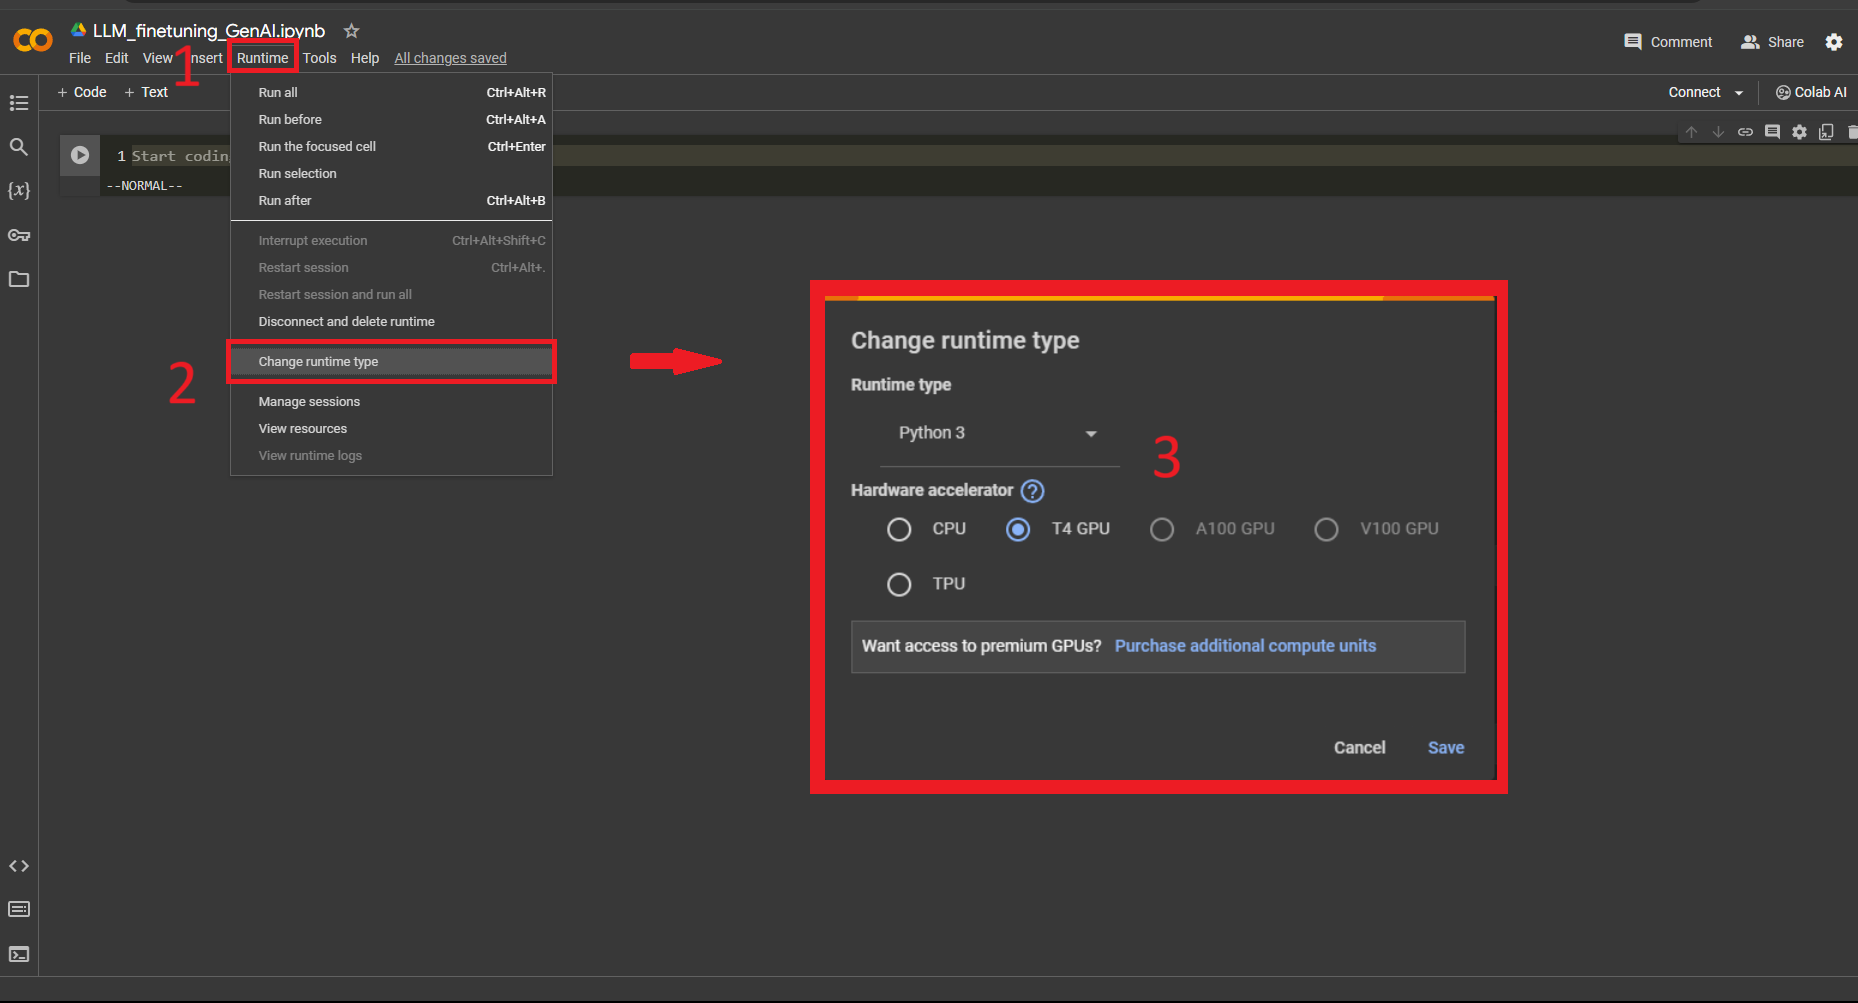

#### Check GPU

In [ ]:
!nvidia-smi

### [Step 0-3] Install Packages (estimated time: < 3 min)

In [ ]:
!pip install transformers==4.50.3
!pip install diffusers==0.33.1
!pip install peft==0.17.1
!pip install huggingface-hub==0.27.0

In [ ]:
import json
import itertools
import logging
import math
import os
import random
from pathlib import Path
from typing import Any, Callable, Dict, List, Optional, Union

import accelerate
import numpy as np
import safetensors
import torch
import torch.nn.functional as F
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as T
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, CLIPTextModel
from safetensors.torch import load_file

import diffusers
from diffusers import StableDiffusionPipeline
from diffusers.pipelines import BlipDiffusionPipeline
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel, DiffusionPipeline
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import CustomDiffusionAttnProcessor, CustomDiffusionAttnProcessor2_0
from diffusers.optimization import get_scheduler
from diffusers.utils import load_image
from diffusers.callbacks import MultiPipelineCallbacks, PipelineCallback
from diffusers.image_processor import PipelineImageInput
from diffusers.utils import deprecate, is_torch_xla_available
from diffusers.pipelines.stable_diffusion.pipeline_output import StableDiffusionPipelineOutput
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion import retrieve_timesteps, rescale_noise_cfg

### [Step 0-4] Download Data

In [ ]:
!git clone https://github.com/hsichelin/GenAI-ML-2025-HW9.git

# Task 1: Observe the Diffusion Process

### [Step 1-1] Visualization (estimated time: < 7 min)

In [ ]:
def viz():
    # Stores intermediate images for visualization
    IMAGES = []

    # Load the Stable Diffusion model and disable the safety checker
    pipe = StableDiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", safety_checker = None)
    pipe = pipe.to("cuda")

    # Callback to capture image steps during generation
    def callback(self, i, t, callback_kwargs):
        latents = callback_kwargs["latents"]

        # Decode current latents to an image tensor using the VAE
        image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False, generator=None)[0]

        if (i % 5 == 0):
            IMAGES.append(image.cpu())

        return callback_kwargs

    prompt = "a photo of an astronaut riding a horse on mars"

    # Run the pipeline, passing the callback to capture steps
    final_image = pipe(prompt, callback_on_step_end = callback).images[0]

    # Create a grid of the captured intermediate images
    diffusion_process = torchvision.utils.make_grid(torch.cat(IMAGES[:-1], dim = 0), 10, normalize = True)
    diffusion_process = T.ToPILImage()(diffusion_process)

    return final_image, diffusion_process

final_image, diffusion_process = viz()

#### Show Diffusion Process

In [ ]:
diffusion_process

#### Show Final Image

In [ ]:
final_image

###  [Step 1-2] Vector Arithmetic During Diffusion Process (estimated time: < 3 min)

#### Define Custom Diffusion Process

In [ ]:
if is_torch_xla_available():
    XLA_AVAILABLE = True
else:
    XLA_AVAILABLE = False

def concat_images(images):
    image = Image.new('RGB', (512 * 4 + 24, 512), 'white')
    x_offset = 0

    for img in images:
        image.paste(img, (x_offset, 0))
        x_offset += (img.width + 8)

    return image

class SDwithNoiseArithmetic(StableDiffusionPipeline):
    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        timesteps: List[int] = None,
        sigmas: List[float] = None,
        guidance_scale: float = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.Tensor] = None,
        prompt_embeds: Optional[torch.Tensor] = None,
        negative_prompt_embeds: Optional[torch.Tensor] = None,
        ip_adapter_image: Optional[PipelineImageInput] = None,
        ip_adapter_image_embeds: Optional[List[torch.Tensor]] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        cross_attention_kwargs: Optional[Dict[str, Any]] = None,
        guidance_rescale: float = 0.0,
        clip_skip: Optional[int] = None,
        callback_on_step_end: Optional[
            Union[Callable[[int, int, Dict], None], PipelineCallback, MultiPipelineCallbacks]
        ] = None,
        callback_on_step_end_tensor_inputs: List[str] = ["latents"],
        **kwargs,
    ):
        callback = kwargs.pop("callback", None)
        callback_steps = kwargs.pop("callback_steps", None)

        if callback is not None:
            deprecate(
                "callback",
                "1.0.0",
                "Passing `callback` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`",
            )
        if callback_steps is not None:
            deprecate(
                "callback_steps",
                "1.0.0",
                "Passing `callback_steps` as an input argument to `__call__` is deprecated, consider using `callback_on_step_end`",
            )

        if isinstance(callback_on_step_end, (PipelineCallback, MultiPipelineCallbacks)):
            callback_on_step_end_tensor_inputs = callback_on_step_end.tensor_inputs

        # 0. Default height and width to unet
        if not height or not width:
            height = (
                self.unet.config.sample_size
                if self._is_unet_config_sample_size_int
                else self.unet.config.sample_size[0]
            )
            width = (
                self.unet.config.sample_size
                if self._is_unet_config_sample_size_int
                else self.unet.config.sample_size[1]
            )
            height, width = height * self.vae_scale_factor, width * self.vae_scale_factor
        # to deal with lora scaling and other possible forward hooks

        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt,
            height,
            width,
            callback_steps,
            negative_prompt,
            prompt_embeds,
            negative_prompt_embeds,
            ip_adapter_image,
            ip_adapter_image_embeds,
            callback_on_step_end_tensor_inputs,
        )

        self._guidance_scale = guidance_scale
        self._guidance_rescale = guidance_rescale
        self._clip_skip = clip_skip
        self._cross_attention_kwargs = cross_attention_kwargs
        self._interrupt = False

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device

        # 3. Encode input prompt
        lora_scale = (
            self.cross_attention_kwargs.get("scale", None) if self.cross_attention_kwargs is not None else None
        )

        prompt_embeds, negative_prompt_embeds = self.encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            self.do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            lora_scale=lora_scale,
            clip_skip=self.clip_skip,
        )

        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        if self.do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

        if ip_adapter_image is not None or ip_adapter_image_embeds is not None:
            image_embeds = self.prepare_ip_adapter_image_embeds(
                ip_adapter_image,
                ip_adapter_image_embeds,
                device,
                batch_size * num_images_per_prompt,
                self.do_classifier_free_guidance,
            )

        # 4. Prepare timesteps
        timesteps, num_inference_steps = retrieve_timesteps(
            self.scheduler, num_inference_steps, device, timesteps, sigmas
        )

        # 5. Prepare latent variables
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )
        latents = torch.stack([latents[0].clone() for _ in range(len(latents))], dim = 0)

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 6.1 Add image embeds for IP-Adapter
        added_cond_kwargs = (
            {"image_embeds": image_embeds}
            if (ip_adapter_image is not None or ip_adapter_image_embeds is not None)
            else None
        )

        # 6.2 Optionally get Guidance Scale Embedding
        timestep_cond = None
        if self.unet.config.time_cond_proj_dim is not None:
            guidance_scale_tensor = torch.tensor(self.guidance_scale - 1).repeat(batch_size * num_images_per_prompt)
            timestep_cond = self.get_guidance_scale_embedding(
                guidance_scale_tensor, embedding_dim=self.unet.config.time_cond_proj_dim
            ).to(device=device, dtype=latents.dtype)

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        self._num_timesteps = len(timesteps)
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                if self.interrupt:
                    continue

                # expand the latents if we are doing classifier free guidance
                latent_model_input = torch.cat([latents] * 2) if self.do_classifier_free_guidance else latents
                if hasattr(self.scheduler, "scale_model_input"):
                    latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                noise_pred = self.unet(
                    latent_model_input,
                    t,
                    encoder_hidden_states=prompt_embeds,
                    timestep_cond=timestep_cond,
                    cross_attention_kwargs=self.cross_attention_kwargs,
                    added_cond_kwargs=added_cond_kwargs,
                    return_dict=False,
                )[0]

                # perform guidance
                if self.do_classifier_free_guidance:
                    noise_pred = self.noise_arithmetic(noise_pred)


                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]

                if callback_on_step_end is not None:
                    callback_kwargs = {}
                    for k in callback_on_step_end_tensor_inputs:
                        callback_kwargs[k] = locals()[k]
                    callback_outputs = callback_on_step_end(self, i, t, callback_kwargs)

                    latents = callback_outputs.pop("latents", latents)
                    prompt_embeds = callback_outputs.pop("prompt_embeds", prompt_embeds)
                    negative_prompt_embeds = callback_outputs.pop("negative_prompt_embeds", negative_prompt_embeds)

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        step_idx = i // getattr(self.scheduler, "order", 1)
                        callback(step_idx, t, latents)

                # if XLA_AVAILABLE:
                #     xm.mark_step()

        if not output_type == "latent":
            image = self.vae.decode(latents / self.vae.config.scaling_factor, return_dict=False, generator=generator)[
                0
            ]
            image, has_nsfw_concept = self.run_safety_checker(image, device, prompt_embeds.dtype)
        else:
            image = latents
            has_nsfw_concept = None

        if has_nsfw_concept is None:
            do_denormalize = [True] * image.shape[0]
        else:
            do_denormalize = [not has_nsfw for has_nsfw in has_nsfw_concept]
        image = self.image_processor.postprocess(image, output_type=output_type, do_denormalize=do_denormalize)

        # Offload all models
        self.maybe_free_model_hooks()

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(images=image, nsfw_content_detected=has_nsfw_concept)


    def noise_arithmetic(self, latents):
        latents_uncond, latents_text = latents.chunk(2)
        cond = latents_text - latents_uncond
        latents = latents_uncond + self.guidance_scale * cond
        latents = arithmetic_func(latents, self.guidance_scale, cond)

        return latents

#### Run Inference

In [ ]:
def arithmetic_func(latents, scale, condition):
    latents[3] = latents[3] + scale * (condition[1] - condition[0])
    return latents

def inference_with_arithmetic():
    pipe = SDwithNoiseArithmetic.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", safety_checker = None)
    pipe = pipe.to("cuda")
    prompt = [
        "A photo of a Welsh Corgi",
        "A photo of a Welsh Corgi in the jungle",
        "A photo of a British Shorthair",
        "A photo of a British Shorthair"
    ]

    images = pipe(prompt, guidance_scale = 12).images
    image = concat_images(images)

    return image

image = inference_with_arithmetic()

#### Show Result Image

In [ ]:
image

#### If the result is different from what the TA said in the video
This demo is not stable. It may not always success. Please watch to following video to observe the result we want to see. [demo](https://www.youtube.com/watch?v=APReFr-eRWU)

### [Step 1-3] Answer quenstions on NTUCOOL

# Task 2-1: Custom Diffusion

### [Step 2-1-1] Define Training Dataset

In [ ]:
class CustomDiffusionDataset(Dataset):
    """
    A dataset to prepare the instance and class images with the prompts for fine-tuning the model.
    It pre-processes the images and the tokenizes prompts.
    """

    def __init__(
        self,
        concepts_list,
        tokenizer,
        size=512,
        mask_size=64,
        center_crop=False,
        with_prior_preservation=False,
        num_class_images=200,
        hflip=False,
        aug=True,
    ):
        self.size = size
        self.mask_size = mask_size
        self.center_crop = center_crop
        self.tokenizer = tokenizer
        self.interpolation = Image.BILINEAR
        self.aug = aug

        self.instance_images_path = []
        self.class_images_path = []
        self.with_prior_preservation = with_prior_preservation
        for concept in concepts_list:
            inst_img_path = [
                (x, concept["instance_prompt"]) for x in Path(concept["instance_data_dir"]).iterdir() if x.is_file()
            ]
            self.instance_images_path.extend(inst_img_path)

            if with_prior_preservation:
                class_data_root = Path(concept["class_data_dir"])
                if os.path.isdir(class_data_root):
                    class_images_path = list(class_data_root.iterdir())
                    class_prompt = [concept["class_prompt"] for _ in range(len(class_images_path))]
                else:
                    with open(class_data_root, "r") as f:
                        class_images_path = f.read().splitlines()
                    with open(concept["class_prompt"], "r") as f:
                        class_prompt = f.read().splitlines()

                class_img_path = list(zip(class_images_path, class_prompt))
                self.class_images_path.extend(class_img_path[:num_class_images])

        random.shuffle(self.instance_images_path)
        self.num_instance_images = len(self.instance_images_path)
        self.num_class_images = len(self.class_images_path)
        self._length = max(self.num_class_images, self.num_instance_images)
        self.flip = transforms.RandomHorizontalFlip(0.5 * hflip)

        self.image_transforms = transforms.Compose(
            [
                self.flip,
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def preprocess(self, image, scale, resample):
        outer, inner = self.size, scale
        factor = self.size // self.mask_size
        if scale > self.size:
            outer, inner = scale, self.size
        top, left = np.random.randint(0, outer - inner + 1), np.random.randint(0, outer - inner + 1)
        image = image.resize((scale, scale), resample=resample)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)
        instance_image = np.zeros((self.size, self.size, 3), dtype=np.float32)
        mask = np.zeros((self.size // factor, self.size // factor))
        if scale > self.size:
            instance_image = image[top : top + inner, left : left + inner, :]
            mask = np.ones((self.size // factor, self.size // factor))
        else:
            instance_image[top : top + inner, left : left + inner, :] = image
            mask[
                top // factor + 1 : (top + scale) // factor - 1, left // factor + 1 : (left + scale) // factor - 1
            ] = 1.0
        return instance_image, mask

    def __getitem__(self, index):
        example = {}
        instance_image, instance_prompt = self.instance_images_path[index % self.num_instance_images]
        instance_image = Image.open(instance_image)
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        instance_image = self.flip(instance_image)

        # apply resize augmentation and create a valid image region mask
        random_scale = self.size
        if self.aug:
            random_scale = (
                np.random.randint(self.size // 3, self.size + 1)
                if np.random.uniform() < 0.66
                else np.random.randint(int(1.2 * self.size), int(1.4 * self.size))
            )
        instance_image, mask = self.preprocess(instance_image, random_scale, self.interpolation)

        if random_scale < 0.6 * self.size:
            instance_prompt = np.random.choice(["a far away ", "very small "]) + instance_prompt
        elif random_scale > self.size:
            instance_prompt = np.random.choice(["zoomed in ", "close up "]) + instance_prompt

        example["instance_images"] = torch.from_numpy(instance_image).permute(2, 0, 1)
        example["mask"] = torch.from_numpy(mask)
        example["instance_prompt_ids"] = self.tokenizer(
            instance_prompt,
            truncation=True,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids

        if self.with_prior_preservation:
            class_image, class_prompt = self.class_images_path[index % self.num_class_images]
            class_image = Image.open(class_image)
            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)
            example["class_mask"] = torch.ones_like(example["mask"])
            example["class_prompt_ids"] = self.tokenizer(
                class_prompt,
                truncation=True,
                padding="max_length",
                max_length=self.tokenizer.model_max_length,
                return_tensors="pt",
            ).input_ids

        return example

### [Step 2-1-2] Define Utility Functions

In [ ]:
def collate_fn(examples):
    """
    Puts together a batch of data.

    Args:
        examples (list of dict): A list of dictionaries, where each dictionary
            contains the keys "instance_prompt_ids", "instance_images", and "mask".

    Returns:
        dict: A dictionary containing the batched "input_ids", "pixel_values", and "mask".
              "input_ids" is a concatenated tensor of prompt token IDs.
              "pixel_values" is a stacked tensor of instance images.
              "mask" is a stacked tensor of masks with an added channel dimension.
    """
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]
    mask = [example["mask"] for example in examples]
    input_ids = torch.cat(input_ids, dim=0) # Concatenate prompt token IDs along the batch dimension.
    pixel_values = torch.stack(pixel_values) # Stack individual image tensors to form the image batch.
    mask = torch.stack(mask) # Stack individual mask tensors to form the mask batch.
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float() # Ensure data is in contiguous memory for potentially faster processing and convert to float.
    mask = mask.to(memory_format=torch.contiguous_format).float() # Ensure mask is in contiguous memory and convert to float.

    batch = {"input_ids": input_ids, "pixel_values": pixel_values, "mask": mask.unsqueeze(1)} # Add a channel dimension to the mask to be compatible with image processing layers.
    return batch

def save_new_embed(text_encoder, modifier_token_id, accelerator, modifier_token, output_dir, safe_serialization=True):
    """Saves the new token embeddings learned by the text encoder.

    Args:
        text_encoder: The trained text encoder model.
        modifier_token_id (list of int): List of token IDs corresponding to the modifier tokens.
        accelerator: The accelerator object used for distributed training.
        modifier_token (list of str): List of the modifier tokens (e.g., ["<new1>"]).
        output_dir (str): The directory where the new embeddings will be saved.
        safe_serialization (bool, optional): Whether to use safe serialization (safetensors). Defaults to True.
    """
    # Unwrap the potentially distributed text encoder model to access its components.
    learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight

    # Iterate through the modifier tokens and their corresponding IDs.
    for x, y in zip(modifier_token_id, [modifier_token]):
        # Create a dictionary to store the learned embedding for the current modifier token.
        learned_embeds_dict = {}
        # Extract the learned embedding for the specific modifier token ID.
        learned_embeds_dict[y] = learned_embeds[x]

        # Determine the filename and saving method based on the safe_serialization flag.
        if safe_serialization:
            filename = f"{output_dir}/{y}.safetensors"
            # Save the learned embedding dictionary using the safetensors format.
            safetensors.torch.save_file(learned_embeds_dict, filename, metadata={"format": "pt"})
        else:
            filename = f"{output_dir}/{y}.bin"
            # Save the learned embedding dictionary using the standard PyTorch format.
            torch.save(learned_embeds_dict, filename)

### [Step 2-1-3] Training Function

In [ ]:
def train_func(
    output_dir,
    instance_prompt,
    instance_data_dir,
    freeze_model,
    learning_rate,
    max_train_steps,
    train_batch_size
):
    accelerator_project_config = ProjectConfiguration(project_dir=output_dir, logging_dir=Path(output_dir, "logs"))

    # create accelerator
    accelerator = Accelerator(
        gradient_accumulation_steps=1,
        mixed_precision=None,
        log_with="tensorboard",
        project_config=accelerator_project_config,
    )

    # Disable AMP for MPS.
    if torch.backends.mps.is_available():
        accelerator.native_amp = False

    # We need to initialize the trackers we use, and also store our configuration.
    # The trackers initializes automatically on the main process.
    if accelerator.is_main_process:
        accelerator.init_trackers("custom-diffusion")

    # Handle the repository creation
    if accelerator.is_main_process and (output_dir is not None):
        os.makedirs(output_dir, exist_ok=True)

    pretrained_model_name_or_path = "stable-diffusion-v1-5/stable-diffusion-v1-5"

    # create tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="tokenizer",
        revision=None,
        use_fast=False,
    )

    # Load scheduler and models
    noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
    text_encoder = CLIPTextModel.from_pretrained(
        pretrained_model_name_or_path, subfolder="text_encoder", revision=None, variant=None
    )
    vae = AutoencoderKL.from_pretrained(
        pretrained_model_name_or_path, subfolder="vae", revision=None, variant=None
    )
    unet = UNet2DConditionModel.from_pretrained(
        pretrained_model_name_or_path, subfolder="unet", revision=None, variant=None
    )

    # Adding a modifier token which is optimized ####
    modifier_token_id = []
    initializer_token_id = []
    modifier_token = "<new1>"
    initializer_token = "ktn"

    # Add the placeholder token in tokenizer
    num_added_tokens = tokenizer.add_tokens(modifier_token)
    if num_added_tokens == 0:
        raise ValueError(
            f"The tokenizer already contains the token {modifier_token}. Please pass a different"
            " `modifier_token` that is not already in the tokenizer."
        )

    # Convert the initializer_token, placeholder_token to ids
    token_ids = tokenizer.encode([initializer_token], add_special_tokens=False)

    # Check if initializer_token is a single token or a sequence of tokens
    if len(token_ids) > 1:
        raise ValueError("The initializer token must be a single token.")

    initializer_token_id.append(token_ids[0])
    modifier_token_id.append(tokenizer.convert_tokens_to_ids(modifier_token))

    # Resize the token embeddings as we are adding new special tokens to the tokenizer
    text_encoder.resize_token_embeddings(len(tokenizer))

    # Initialise the newly added placeholder token with the embeddings of the initializer token
    token_embeds = text_encoder.get_input_embeddings().weight.data
    for x, y in zip(modifier_token_id, initializer_token_id):
        token_embeds[x] = token_embeds[y]

    # Freeze all parameters except for the token embeddings in text encoder
    params_to_freeze = itertools.chain(
        text_encoder.text_model.encoder.parameters(),
        text_encoder.text_model.final_layer_norm.parameters(),
        text_encoder.text_model.embeddings.position_embedding.parameters(),
    )
    for param in params_to_freeze:
        param.requires_grad = False

    vae.requires_grad_(False)
    if modifier_token is None:
        text_encoder.requires_grad_(False)
    unet.requires_grad_(False)

    # For mixed precision training we cast the text_encoder and vae weights to half-precision
    # as these models are only used for inference, keeping weights in full precision is not required.
    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move unet, vae and text_encoder to device and cast to weight_dtype
    if accelerator.mixed_precision != "fp16" and modifier_token is not None:
        text_encoder.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)
    vae.to(accelerator.device, dtype=weight_dtype)

    attention_class = (
        CustomDiffusionAttnProcessor2_0 if hasattr(F, "scaled_dot_product_attention") else CustomDiffusionAttnProcessor
    )

    # now we will add new Custom Diffusion weights to the attention layers
    # It's important to realize here how many attention weights will be added and of which sizes
    # The sizes of the attention layers consist only of two different variables:
    # 1) - the "hidden_size", which is increased according to `unet.config.block_out_channels`.
    # 2) - the "cross attention size", which is set to `unet.config.cross_attention_dim`.

    # Let's first see how many attention processors we will have to set.
    # For Stable Diffusion, it should be equal to:
    # - down blocks (2x attention layers) * (2x transformer layers) * (3x down blocks) = 12
    # - mid blocks (2x attention layers) * (1x transformer layers) * (1x mid blocks) = 2
    # - up blocks (2x attention layers) * (3x transformer layers) * (3x down blocks) = 18
    # => 32 layers

    # Only train key, value projection layers if freeze_model = 'crossattn_kv' else train all params in the cross attention layer
    train_kv = True
    train_q_out = False if freeze_model == "crossattn_kv" else True
    custom_diffusion_attn_procs = {}

    st = unet.state_dict()
    for name, _ in unet.attn_processors.items():
        cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
        if name.startswith("mid_block"):
            hidden_size = unet.config.block_out_channels[-1]
        elif name.startswith("up_blocks"):
            block_id = int(name[len("up_blocks.")])
            hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
        elif name.startswith("down_blocks"):
            block_id = int(name[len("down_blocks.")])
            hidden_size = unet.config.block_out_channels[block_id]
        layer_name = name.split(".processor")[0]
        weights = {
            "to_k_custom_diffusion.weight": st[layer_name + ".to_k.weight"],
            "to_v_custom_diffusion.weight": st[layer_name + ".to_v.weight"],
        }
        if train_q_out:
            weights["to_q_custom_diffusion.weight"] = st[layer_name + ".to_q.weight"]
            weights["to_out_custom_diffusion.0.weight"] = st[layer_name + ".to_out.0.weight"]
            weights["to_out_custom_diffusion.0.bias"] = st[layer_name + ".to_out.0.bias"]
        if cross_attention_dim is not None:
            custom_diffusion_attn_procs[name] = attention_class(
                train_kv=train_kv,
                train_q_out=train_q_out,
                hidden_size=hidden_size,
                cross_attention_dim=cross_attention_dim,
            ).to(unet.device)
            custom_diffusion_attn_procs[name].load_state_dict(weights)
        else:
            custom_diffusion_attn_procs[name] = attention_class(
                train_kv=False,
                train_q_out=False,
                hidden_size=hidden_size,
                cross_attention_dim=cross_attention_dim,
            )
    del st
    unet.set_attn_processor(custom_diffusion_attn_procs)
    custom_diffusion_layers = AttnProcsLayers(unet.attn_processors)
    accelerator.register_for_checkpointing(custom_diffusion_layers)

    # rescale learning rate
    learning_rate = learning_rate * train_batch_size * accelerator.num_processes

    # Optimizer creation
    optimizer = torch.optim.AdamW(
        itertools.chain(text_encoder.get_input_embeddings().parameters(), custom_diffusion_layers.parameters())
        if modifier_token is not None
        else custom_diffusion_layers.parameters(),
        lr=learning_rate,
        betas=(0.9, 0.999),
        weight_decay=1e-2,
        eps=1e-8
    )

    # Dataset and DataLoaders creation:
    concepts_list = [
        {
            "instance_prompt": instance_prompt,
            "class_prompt": None,
            "instance_data_dir": instance_data_dir,
            "class_data_dir": None,
        }
    ]
    resolution = 512

    train_dataset = CustomDiffusionDataset(
        concepts_list=concepts_list,
        tokenizer=tokenizer,
        size=resolution,
        mask_size=vae.encode(
            torch.randn(1, 3, resolution, resolution).to(dtype=weight_dtype).to(accelerator.device)
        ).latent_dist.sample().size()[-1],
        center_crop=False,
        hflip=True,
        aug=False,
    )

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        shuffle=True,
        collate_fn=lambda examples: collate_fn(examples),
        num_workers=2,
    )

    # Scheduler and math around the number of training steps.
    # Check the PR https://github.com/huggingface/diffusers/pull/8312 for detailed explanation.
    num_warmup_steps_for_scheduler = 0
    num_training_steps_for_scheduler = max_train_steps * accelerator.num_processes

    lr_scheduler = get_scheduler(
        "constant",
        optimizer=optimizer,
        num_warmup_steps=num_warmup_steps_for_scheduler,
        num_training_steps=num_training_steps_for_scheduler,
    )

    # Prepare everything with our `accelerator`.
    if modifier_token is not None:
        custom_diffusion_layers, text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            custom_diffusion_layers, text_encoder, optimizer, train_dataloader, lr_scheduler
        )
    else:
        custom_diffusion_layers, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            custom_diffusion_layers, optimizer, train_dataloader, lr_scheduler
        )

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = len(train_dataloader)
    # Afterwards we recalculate our number of training epochs
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    global_step = 0
    first_epoch = 0
    initial_global_step = 0

    # progress bar
    progress_bar = tqdm(
        range(0, max_train_steps),
        initial=initial_global_step,
        desc="Steps",
        # Only show the progress bar once on each machine.
        disable=not accelerator.is_local_main_process,
    )

    for epoch in range(first_epoch, num_train_epochs):
        unet.train()
        if modifier_token is not None:
            text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet), accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
                latents = latents * vae.config.scaling_factor

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
                timesteps = timesteps.long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                mask = batch["mask"]
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="none")
                loss = ((loss * mask).sum([1, 2, 3]) / mask.sum([1, 2, 3])).mean()
                accelerator.backward(loss)
                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if modifier_token is not None:
                    if accelerator.num_processes > 1:
                        grads_text_encoder = text_encoder.module.get_input_embeddings().weight.grad
                    else:
                        grads_text_encoder = text_encoder.get_input_embeddings().weight.grad
                    # Get the index for tokens that we want to zero the grads for
                    index_grads_to_zero = torch.arange(len(tokenizer)) != modifier_token_id[0]
                    for i in range(1, len(modifier_token_id)):
                        index_grads_to_zero = index_grads_to_zero & (
                            torch.arange(len(tokenizer)) != modifier_token_id[i]
                        )
                    grads_text_encoder.data[index_grads_to_zero, :] = grads_text_encoder.data[
                        index_grads_to_zero, :
                    ].fill_(0)

                if accelerator.sync_gradients:
                    params_to_clip = (
                        itertools.chain(text_encoder.parameters(), custom_diffusion_layers.parameters())
                        if modifier_token is not None
                        else custom_diffusion_layers.parameters()
                    )
                    accelerator.clip_grad_norm_(params_to_clip, 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad(set_to_none=False)

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

                if accelerator.is_main_process and (global_step == max_train_steps):
                    save_path = os.path.join(output_dir, f"checkpoint-{global_step}")
                    accelerator.save_state(save_path)

            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)

            if global_step >= max_train_steps:
                break

    # Save the custom diffusion layers
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        unet = unet.to(torch.float32)
        unet.save_attn_procs(output_dir, safe_serialization=True)
        save_new_embed(
            text_encoder,
            modifier_token_id,
            accelerator,
            modifier_token,
            output_dir,
            safe_serialization=True,
        )

    accelerator.end_training()

### [Step 2-1-4] Hyperparameters (TODO)

In [ ]:
##################### TODO: Tune hyperparameters here ##########################

instance_prompt = "photo of a <new1> statue"    # The text prompt used for training
parameter_to_train = "crossattn_kv"             # "crossattn_kv" only train the K V in cross attention. Change this to "crossattn" if you also want to train Q
learning_rate = 1e-6
max_train_steps = 250
train_batch_size = 2

################################################################################

instance_data_dir = "GenAI-ML-2025-HW9/data/custom_diffusion"     # Path to images of the object to customize
ckpt_dir = "ckpt"                             # directory name to save checkpoints

### [Step 2-1-5] Start Training (estimated time: < 80 min)

In [ ]:
accelerate.notebook_launcher(train_func, args=(ckpt_dir, instance_prompt, instance_data_dir, parameter_to_train, learning_rate, max_train_steps, train_batch_size))

### [Step 2-1-6] Load Fine-tuned Model (estimated time: < 1 min)

In [ ]:
pipe = DiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16, safety_checker = None
).to("cuda")

state_dict = load_file(os.path.join(ckpt_dir, "pytorch_custom_diffusion_weights.safetensors"), device = "cpu")
custom_attn = pipe.unet._process_custom_diffusion(state_dict=state_dict)
attn_procs = pipe.unet.attn_processors
attn_procs.update(custom_attn)
pipe.unet.set_attn_processor(attn_procs)
pipe.unet.to(dtype = pipe.unet.dtype, device = pipe.unet.device)

pipe.load_textual_inversion(ckpt_dir, weight_name="<new1>.safetensors")

### [Step 2-1-7] Inference (TODO) (estimated time: < 15 min)

In [ ]:
##################### TODO: Tune hyperparameters here ##########################

generate_prompt = "a <new1> statue in the snow" # text prompt to generate images (make sure the condition is correct if you are not customizing for object5)
                                                # WARNING: if you modified "instance_prompt" for training you would like to modify this correspondingly
                                                #          e.g., If your instanace_prompt is "photo of a <new1> animal plushie" you would like to use "a <new1> animal plushie on a plate"

num_inference_steps = 100   # The number of denoising steps. More denoising steps usually lead to a higher quality image at the expense of slower inference.
guidance_scale = 6.0        # Higher guidance scale encourages to generate images that are closely linked to the text prompt, usually at the expense of lower image quality.

################################################################################

obj = instance_data_dir.split("/")[-1]
output_dir = "results_custom_diffusion"
os.makedirs(f"{output_dir}", exist_ok = True)
num_images = 30             # The number of images you want to generate.
                            # WARNING: You MUST to keep it 30 if you want to generate the images for submission.
                            # But you can reduce it when tuning hyperparameters to speed up the process

for i in range(num_images):
    image = pipe(
        generate_prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        eta=1.0,
    ).images[0]
    image.save(f"{output_dir}/{i}.jpg")

### [Step 2-1-8] Archive Results

In [ ]:
from google.colab import files
os.system(f"zip -r {output_dir}.zip {output_dir}")      # create zipped file for submission
files.download(f"{output_dir}.zip")

# Task 2-2: BLIP-Diffusion

### [Step 2-2-1] Define Inference Function

In [ ]:
def InferenceBlipDiffusion(
    pipe,
    cond_image_path,
    name,
    text_prompt_input,
    guidance_scale,
    num_inference_steps,
    saveDir,
    num_images
):
    """
    Performs inference using a Blip Diffusion pipeline to generate images based on a conditional image and text prompt.

    Args:
        pipe: The Blip Diffusion pipeline object.
        cond_image_path (str): The file path to the conditioning image. This image guides the style and content of the generated images.
        name (str): A descriptive name associated with the subject or concept in the conditioning image. This name is used for both the conditioning and target subjects.
        text_prompt_input (str): The text prompt that provides additional information and guides the generation of the new images.
        guidance_scale (float): A value controlling the influence of the text prompt on the generated images. Higher values enforce the prompt more strongly.
        num_inference_steps (int): The number of denoising steps to perform during the diffusion process. More steps generally lead to higher quality images but take longer to generate.
        saveDir (str): The directory where the generated images will be saved. The function will create this directory if it doesn't exist.
        num_images (int): The number of images to generate.

    Returns:
        None. The generated images are saved to the specified `saveDir`.
    """

    os.makedirs(saveDir, exist_ok = True) # create output directory
    # prepare arguments for BLIP Diffusion
    cond_subject = name
    tgt_subject = name
    cond_image = load_image(cond_image_path)
    negative_prompt = "over-exposure, under-exposure, saturated, duplicate, out of frame, lowres, cropped, worst quality, low quality, jpeg artifacts, morbid, mutilated, out of frame, ugly, bad anatomy, bad proportions, deformed, blurry, duplicate"

    for i in range(num_images):
        output = pipe(
            text_prompt_input,
            cond_image,
            cond_subject,
            tgt_subject,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
            neg_prompt=negative_prompt,
            height=512,
            width=512,
        ).images
        output[0].save(f"{saveDir}/{i}.jpg")

### [Step 2-2-2] Create BLIP Diffusion Pipeline (estimated time: < 4 min)

In [ ]:
blip_diffusion_pipe = BlipDiffusionPipeline.from_pretrained("Salesforce/blipdiffusion", mean = None, std = None).to("cuda")

### [Step 2-2-3] Inference (TODO)  (estimated time: < 40 min)

In [ ]:
##################### TODO: Tune hyperparameters here ##########################

num_inference_steps = 10    # The number of denoising steps. More denoising steps usually lead to a higher quality image at the expense of slower inference.
guidance_scale = 2          # Higher guidance scale encourages to generate images that are closely linked to the text prompt, usually at the expense of lower image quality.

################################################################################

num_images = 30             # The number of images you want to generate.
                            # WARNING: You MUST to keep it 30 if you want to generate the images for submission.
                            # But you can reduce it when tuning hyperparameters to speed up the process
output_dir = "results_blip_diffusion"
InferenceBlipDiffusion(
    pipe = blip_diffusion_pipe,
    cond_image_path = "GenAI-ML-2025-HW9/data/blip_diffusion/0.jpg",
    name = "dog",
    text_prompt_input = "with sunglasses",
    guidance_scale = guidance_scale,
    num_inference_steps = num_inference_steps,
    saveDir = output_dir,
    num_images = num_images
)

### [Step 2-2-4] Archive Results

In [ ]:
from google.colab import files
os.system(f"zip -r {output_dir}.zip {output_dir}")      # create zipped file for submission
files.download(f"{output_dir}.zip")